<a href="https://colab.research.google.com/github/lucianozablocki/tiny_md/blob/main/cp_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
print(f"Length of original df: {len(df)}")
print("\nUnique values in each column:")
print(f"N values: {df['N'].unique()}")
print(f"opt flags: {df['opt'].unique()}")
print(f"compilers: {df['compiler'].unique()}")

Length of original df: 520

Unique values in each column:
N values: [  4  32 108 256 500]
opt flags: ['-O0' '-O1' '-O2' '-O3' '-Ofast']
compilers: ['gcc' 'clang']


In [ ]:
# Create a cross product of all possible combinations
compilers = ['gcc', 'clang']
opt_flags = ['-O0', '-O1', '-O2', '-O3', '-Ofast']
Ns = [4*m**3 for m in range(1,5+1)]  # [4, 32, 108, 256, 500]

# Create all possible combinations
all_combinations = pd.MultiIndex.from_product(
    [Ns, opt_flags, compilers],
    names=['N', 'opt', 'compiler']
).to_frame(index=False)

# Count measurements for each combination
counts = df.groupby(['N', 'opt', 'compiler']).size().reset_index(name='count')

# Merge to see which combinations have fewer than 5 measurements
analysis = all_combinations.merge(counts, how='left', on=['N', 'opt', 'compiler'])

# Print summary statistics
print("\nSummary:")
print(f"Total rows in df: {len(df)}")
print("\nMeasurement counts:")
print(analysis['count'].value_counts())


Summary:
Total rows in df: 520

Measurement counts:
count
20    10
15    10
10    10
5     10
2     10
Name: count, dtype: int64


In [20]:
def plot_results_for(file_name, df):
  plt.figure(figsize=(15, 6))
  #plt.title(file_name)

  df_max = df.groupby(['N', 'opt', 'compiler'])['particulas/s'].max().reset_index()
  df=df_max

  df_max2 = df.groupby(['N', 'compiler'])['particulas/s'].max().reset_index()

  # Plot for GCC
  plt.subplot(1, 2, 1)
  for opt in df['opt'].unique():
      data = df[(df['compiler'] == 'gcc') & (df['opt'] == opt)]
      plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

  plt.title(f'{file_name} using GCC Performance')
  plt.xlabel('N (number of particles)')
  plt.ylabel('Particles/s')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)

  plt.ylim(1, 1000)
  plt.xlim(0, 550)

  # Plot for Clang
  #plt.subplot(1, 2, 2)
  #for opt in df['opt'].unique():
  #    data = df[(df['compiler'] == 'clang') & (df['opt'] == opt)]
  #    plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

  #plt.title('Clang Performance')
  #plt.xlabel('N (number of particles)')
  #plt.ylabel('Particles/s')
  #plt.yscale('log')
  #plt.legend()
  #plt.grid(True)

  #plt.ylim(1, 1000)
  #plt.xlim(0, 550)

  #plt.suptitle(f'Results for {file_name}')

  # Adjust layout to prevent overlap
  plt.tight_layout()

Processing file: atom-native


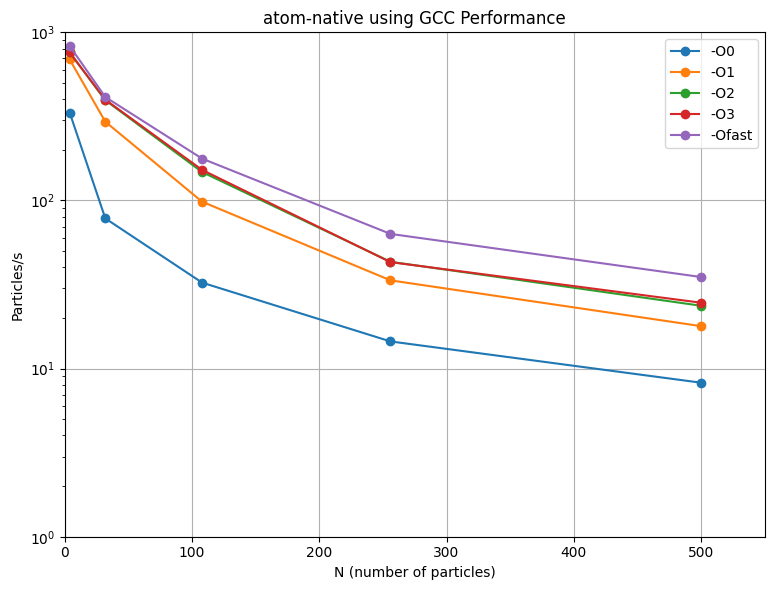

In [21]:
files = ['atom-native']#, 'atom-native']#,
#         'jupiterace', 'jupiterace-native']
df = None
for file_name in files:
  print(f"Processing file: {file_name}")
  df = pd.read_csv(f"https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/{file_name}.csv")
  plot_results_for(file_name, df)

In [11]:
def print_results_for(df):
  df_sorted = df.sort_values('particulas/s', ascending=False)
  df_max_per_N = df_sorted.groupby('N').first().reset_index()
  print(df_max_per_N)

In [12]:
files = ['atom', 'atom-native',
         'jupiterace', 'jupiterace-native']
df = None
for file_name in files:
  print(f"Processing file: {file_name}")
  df = pd.read_csv(f"https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/{file_name}.csv")
  print_results_for(df)

Processing file: atom
     N  particulas/s     opt compiler  runs
0    4       739.739  -Ofast    clang    20
1   32       378.422     -O3      gcc    15
2  108       146.696     -O3      gcc    10
3  256        42.426  -Ofast      gcc     5
4  500        23.278  -Ofast      gcc     2
Processing file: atom-native
     N  particulas/s     opt compiler  runs
0    4       829.170  -Ofast      gcc    20
1   32       427.275     -O3    clang    15
2  108       177.365  -Ofast      gcc    10
3  256        63.256  -Ofast      gcc     5
4  500        35.041  -Ofast      gcc     2
Processing file: jupiterace
     N  particulas/s     opt compiler  runs
0    4       578.933  -Ofast    clang    20
1   32       263.505     -O3      gcc    15
2  108        72.996  -Ofast    clang    10
3  256        35.762  -Ofast      gcc     5
4  500        22.030  -Ofast      gcc     2
Processing file: jupiterace-native
     N  particulas/s     opt compiler  runs
0    4       564.370  -Ofast      gcc    20
1   32

In [16]:
import pandas as pd

def print_benchmark_results(results):
  df = pd.read_csv(results, sep='\t', header=None, names=['size', 'time', 'MFLOPS'])

  # Remove the 's' from time and ' MFLOPS' from MFLOPS and convert them to numeric
  df['time'] = df['time'].str.replace(' s', '').astype(float)
  df['MFLOPS'] = df['MFLOPS'].str.replace(' MFLOPS', '').astype(float)

  # Convert MFLOPS to TFLOPS
  df['TFLOPS'] = df['MFLOPS'] / 1_000_000  # Convert MFLOPS to TFLOPS
  df = df.drop(columns=['MFLOPS'])  # Remove the MFLOPS column

  # Group the data by 'size'
  grouped = df.groupby('size')

  # Calculate average time and TFLOPS for each size
  avg_time = grouped['time'].mean()
  avg_tflops = grouped['TFLOPS'].mean()

  # Find the row with max TFLOPS for each size
  max_tflops_row = grouped['TFLOPS'].idxmax()  # Find the index of the max TFLOPS per group
  max_tflops_row = df.loc[max_tflops_row]  # Use the indices to get the corresponding rows

  # Output the results
  #print(f"\nAverage Time:\n{avg_time}\n")
  print(f"Average TFLOPS:\n{avg_tflops}\n")
  print(f"Row with Max TFLOPS:\n{max_tflops_row}")

In [17]:
# Read the CSV file with tab separation
file_path = "/content/timeSGEMM-atom.txt"  # Replace with your file path
PCs = ['jupiterace', 'atom']
n = 50
print('=' * n)
for pc in PCs:
  print(f"Results for: {pc}")
  print('-' * n)
  print('Results for SGEMM benchmark')
  print_benchmark_results(f"/content/timeSGEMM-{pc}.txt")
  print('-' * n)
  print('Results for DGEMM benchmark')
  print_benchmark_results(f"/content/timeDGEMM-{pc}.txt")
  print('=' * n)

Results for: jupiterace
--------------------------------------------------
Results for SGEMM benchmark
Average TFLOPS:
size
16384x16384x16384    1.695875
32768x32768x32768    1.749497
Name: TFLOPS, dtype: float64

Row with Max TFLOPS:
                 size       time    TFLOPS
0   16384x16384x16384   4.992642  1.761811
10  32768x32768x32768  39.646747  1.774893
--------------------------------------------------
Results for DGEMM benchmark
Average TFLOPS:
size
32768x32768x32768    0.690416
Name: TFLOPS, dtype: float64

Row with Max TFLOPS:
                size       time    TFLOPS
0  32768x32768x32768  89.054287  0.790178
Results for: atom
--------------------------------------------------
Results for SGEMM benchmark
Average TFLOPS:
size
16384x16384x16384    2.027263
32768x32768x32768    2.208652
Name: TFLOPS, dtype: float64

Row with Max TFLOPS:
                 size       time    TFLOPS
8   16384x16384x16384   4.114502  2.137827
19  32768x32768x32768  29.875342  2.355412
-------------